<a href="https://colab.research.google.com/github/AlviJohn/AmazonRecoEngine/blob/main/Product_Recommendation__V4(With_Features).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
## Importing required libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import os
import gzip
import json
from google.colab import drive
import gc
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score, roc_auc_score, precision_score, recall_score, confusion_matrix
## Amazon Dataset --https://nijianmo.github.io/amazon/index.html
###Mounting Google Drive

In [56]:
##Mounting the Path
drive.mount('/content/drive')
path ="/content/drive/MyDrive/LJMU Research Topic/colab_experiments/data"
RAWDATA_PATH = path + "/raw"
EMBEDDINGSDATA_PATH = path + "/embeddings"
os.chdir(RAWDATA_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset Definition**

In [57]:
# Define a custom dataset class for reading the data

class AmazonDataset(Dataset):
    def __init__(self, data,idx_to_item,image_embeddings,desc_embeddings):
        self.data = data
        self.idx_to_item = idx_to_item
        self.image_embeddings=image_embeddings
        self.desc_embeddings=desc_embeddings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user = self.data.iloc[idx, 0]
        item = self.data.iloc[idx, 1]
        relevance_score = self.data.iloc[idx, 2]
        
        itemimage_embedding = self.image_embeddings.get(idx_to_item[item],torch.zeros(25088))
        itemdesc_embedding = self.desc_embeddings.get(idx_to_item[item],torch.zeros(768))

        return user, item, relevance_score,itemimage_embedding,itemdesc_embedding


In [58]:
# Define the model
class RecommenderNet(torch.nn.Module):
    def __init__(self, n_users, n_items,n_image_embedding,n_desc_embedding, n_factors=64,dropout_prob=0.2):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(n_users, n_factors)
        self.item_embedding = torch.nn.Embedding(n_items, n_factors)
        
        self.image_embedding_layer = torch.nn.Linear(n_image_embedding, n_factors)
        self.desc_embedding_layer = torch.nn.Linear(n_desc_embedding, n_factors)
        
        self.fc1 = torch.nn.Linear(n_factors*4, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)

        self.dropout = torch.nn.Dropout(dropout_prob)

    def forward(self, user, item,itemimage_embedding,itemdesc_embedding):
       
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        
        itemimage_embedding = self.image_embedding_layer(itemimage_embedding).unsqueeze(1)
        itemdesc_embedding = self.desc_embedding_layer(itemdesc_embedding).unsqueeze(1)

        user_embedding = torch.nn.functional.relu(user_embedding)
        user_embedding =self.dropout(user_embedding)
        item_embedding = torch.nn.functional.relu(item_embedding)
        item_embedding =self.dropout(item_embedding)
        itemimage_embedding = torch.nn.functional.relu(itemimage_embedding)
        itemimage_embedding =self.dropout(itemimage_embedding)
        itemdesc_embedding = torch.nn.functional.relu(itemdesc_embedding)
        itemdesc_embedding =self.dropout(itemdesc_embedding)

        vector = torch.cat([user_embedding, item_embedding,itemimage_embedding,itemdesc_embedding], dim=-1)
        vector = torch.nn.functional.relu(self.fc1(vector))
        vector = self.dropout(vector)
        vector = torch.nn.functional.relu(self.fc2(vector))
        vector = self.dropout(vector)
        vector = self.fc3(vector)
        vector = torch.sigmoid(vector).float()
        return vector.squeeze().float()

**Model Training**

In [59]:
######Loading Image embeddings
image_embeddings=torch.load(EMBEDDINGSDATA_PATH + '/productimage_embeddings.pt')
description_embeddings=torch.load(EMBEDDINGSDATA_PATH +'/productdescription_embeddings.pt')

In [60]:
####Loading the ratings dataset
df = pd.read_csv('user_item_rating.csv')
df = df[["reviewerID","asin","overall","unixReviewTime"]]

##Assigning all positive rating as 1
df['overall'] =1
###Taking Unique User IDs and Product IDs
user_unique = df['reviewerID'].unique()
product_unique= df['asin'].unique()

###Creating index for UserID and Product ID
user_to_idx = {v:k for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(product_unique)}

idx_to_user = {k:v for k,v in enumerate(user_unique)}
idx_to_item = {k:v for k,v in enumerate(product_unique)}

df= df.replace({"reviewerID": user_to_idx,"asin": item_to_idx})

df.head()

<ipython-input-60-69e042926e97>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overall'] =1


,reviewerID,asin,overall,unixReviewTime
0,0,0,1,1441324800
1,0,0,1,1441324800
2,0,0,1,1441324800
3,0,0,1,1441324800
4,0,0,1,1441324800


In [61]:
###Assigning all the latest to test dataset
df['rank_latest'] = df.groupby(['reviewerID'])['unixReviewTime'] \
                                .rank(method = 'first',ascending=False)

train_data = df[df['rank_latest'] != 1]
test_data = df[df['rank_latest'] == 1]

#test_data,train_data = train_test_split(df, test_size=0.8)
# drop columns that we no Longer need 
train_data = train_data[["reviewerID","asin","overall"]]
test_data = test_data[["reviewerID","asin","overall"]]


display(train_data.shape)
display(test_data.shape)

(2770, 3)

(406, 3)

Negative Sampling for train dataset

In [62]:
# Get a list of all products
all_Ids = train_data['asin'].unique()

users, items, labels = [], [], []
user_item_set = set(zip(train_data['reviewerID'], train_data['asin']))   

######Setting 4 negative sample for every positive sample
num_negatives = 4
for u, i in user_item_set:
  users.append(u)
  items.append(i)
  labels.append(1)
  for _ in range(num_negatives):
    negative_item = np.random.choice(all_Ids)
    while (u, negative_item) in user_item_set:
      negative_item = np.random.choice(all_Ids)
    users.append(u)
    items.append(i)
    labels.append(0)
                     
train_data = pd.DataFrame({'reviewerID':users, 'asin':items, 'overall':labels})

###Setting 20% of Train Dataset as Validation Dataset
train_data, val_data = train_test_split(train_data, test_size=0.2)
display(val_data.shape)
display(train_data.shape)


(2666, 3)

(10664, 3)

In [63]:
# Define the data loaders
train_dataset = AmazonDataset(train_data,idx_to_item,image_embeddings,description_embeddings)
val_dataset = AmazonDataset(val_data,idx_to_item,image_embeddings,description_embeddings)
test_dataset = AmazonDataset(test_data,idx_to_item,image_embeddings,description_embeddings)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [64]:
# Initialize the model and hyperparameters
model = RecommenderNet(n_users=(df.reviewerID.max()+1),\
                       n_items=(df.asin.max()+1),n_image_embedding=25088,n_desc_embedding=768,n_factors=64)


criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [65]:
model

RecommenderNet(
  (user_embedding): Embedding(406, 64)
  (item_embedding): Embedding(31, 64)
  (image_embedding_layer): Linear(in_features=25088, out_features=64, bias=True)
  (desc_embedding_layer): Linear(in_features=768, out_features=64, bias=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1, Training Loss: 0.5350549238778296, Validation Loss: 0.5110704217638288
Epoch 2, Training Loss: 0.5195072314568928, Validation Loss: 0.5040516981056758
Epoch 3, Training Loss: 0.5162620579912549, Validation Loss: 0.51051417135057
Epoch 4, Training Loss: 0.518536525113242, Validation Loss: 0.5074813706534249
Epoch 5, Training Loss: 0.513208939560822, Validation Loss: 0.5044768665518079
Epoch 6, Training Loss: 0.5153649569976897, Validation Loss: 0.4958035293079558
Epoch 7, Training Loss: 0.5124321289005733, Validation Loss: 0.5027640078748975
Epoch 8, Training Loss: 0.5118144402901331, Validation Loss: 0.5011510565167382
Epoch 9, Training Loss: 0.5133230533628237, Validation Loss: 0.5053813060124716
Epoch 10, Training Loss: 0.5124425047210285, Validation Loss: 0.49984563958077205
Epoch 11, Training Loss: 0.5125172255294663, Validation Loss: 0.49888430322919575
Epoch 12, Training Loss: 0.5115453320599738, Validation Loss: 0.5022114401771909
Epoch 13, Training Loss: 0.509395994600

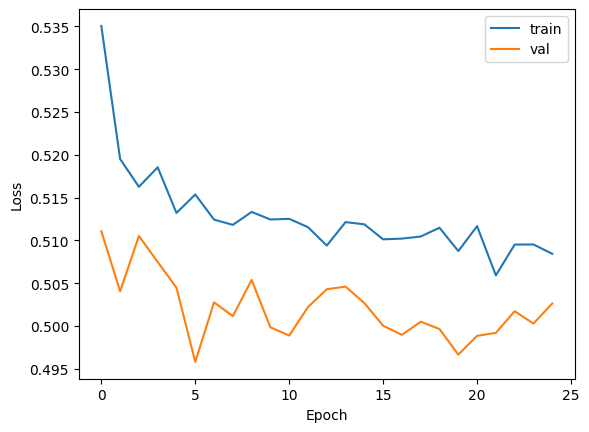

In [66]:
# Training the model
train_losses = []
val_losses = []

epochs = 25
for epoch in range(epochs):
    train_loss = 0.0
    for user, item, relevance_score,itemimage_embedding,itemdesc_embedding in train_loader:
        optimizer.zero_grad()
        user=user.view(-1, 1)
        item = item.view(-1, 1)
        #relevance_score = relevance_score.squeeze()
        #relevance_score = relevance_score.view(-1, 1).float()
        predicted_score = model(user, item,itemimage_embedding,itemdesc_embedding)
        # print(relevance_score)
        # print(predicted_score)
        loss = criterion(predicted_score, relevance_score.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))

  # Validation
    val_loss = 0.0
    with torch.no_grad():
        for user, item, relevance_score,itemimage_embedding,itemdesc_embedding in val_loader:
            user=user.view(-1, 1)
            item = item.view(-1, 1)
            #relevance_score = relevance_score.squeeze()
            predicted_score = model(user, item,itemimage_embedding,itemdesc_embedding)
            loss = criterion(predicted_score, relevance_score.float())
            val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

# Print the loss for each epoch
    print(f"Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")

# Plot loss curves
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [71]:
###Testing the Model with HIT 10
# User-item pairs for testing
test_user_item_set = set(zip(test_data['reviewerID'], test_data['asin']))
# Dict of all items that are interacted with by each user
user_interacted_items = train_data.groupby('reviewerID')['asin'].apply(list).to_dict()
all_Ids = train_data['asin'].unique()


hits = []
ndcg=[]
auc=[]

for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_Ids) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    item_image_embedding_tensors = [image_embeddings.get(idx_to_item[item_id],torch.zeros(25088)) for item_id in test_items]
    item_desc_embedding_tensors = [description_embeddings.get(idx_to_item[item_id],torch.zeros(768)) for item_id in test_items]

    item_image_embedding_tensors = torch.stack(item_image_embedding_tensors)
    item_desc_embedding_tensors= torch.stack(item_desc_embedding_tensors)
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100).view(-1,1),\
                                        torch.tensor(test_items).view(-1,1),\
                                        item_image_embedding_tensors,item_desc_embedding_tensors).detach().numpy())
    
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    actual_labels = np.zeros(100)
    actual_labels[-1] = 1
    
    # NDCG calculation
    ndcg.append(ndcg_score([actual_labels], [predicted_labels]))

    # AUC calculation
    auc.append(roc_auc_score(actual_labels, predicted_labels))
    

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))
print("The AUC is {:.2f}".format(np.average(auc)))
print("The NDCG is {:.2f}".format(np.average(ndcg)))

  0%|          | 0/406 [00:00<?, ?it/s]

The Hit Ratio @ 10 is 0.29
The AUC is 0.52
The NDCG is 0.20
